# 3A.mr - Graphes et Map Reduce

Les graphes sont des structures de données difficiles à manipuler avec des concepts map/reduce car les données ne sont pas indépendantes et la notion de voisinage est importante. Ce notebook explore ces difficultés.

In [ ]:
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


On suppose qu'on a un graphe $G(V,E)$ pour lequel on cherche à déterminer la distance de tous les noeuds à un noeud précis du graphe. Si calculer cette distance pour un graphe de petite taille ne pose pas de problème, pour un grand graphe, cela peut se révéler plus complexe. L'idée de cet exercice est de montrer que les concepts Map Reduce ne sont pas bien adaptés à cela. Pour un grand graphe (plusieurs dizaines de millions de noeuds), le calcul est soit trop long à faire sur un seul ordinateur, soit cet ordinateur ne peut tout simplement pas contenir tout le graphe. Il faut alors répartir ce calcul sur plusieurs machines. Mais commençons d'abord par un graphe simple et symétrique : si on peut passer d'un noeud $v$ à $v'$, le chemin en sens inverse est possible.

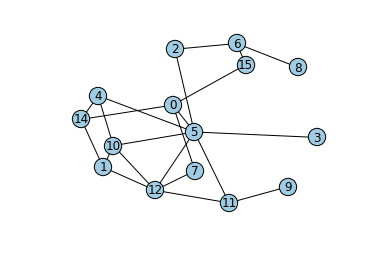

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import random
G = nx.Graph()
G.add_edge(0,5)
n = 15
labels={0:"0",5:"5"}
for i in range(0,30):
    a,b = random.randint(0,n),random.randint(0,n)
    G.add_edge(b,a)
    labels[a]=str(a)
    labels[b]=str(b)
pos=nx.spring_layout(G)
nx.draw_networkx_labels(G,pos,labels)
nx.draw(G,pos,node_color='#A0CBE2')

Par exemple, les noeuds 0 et 5 sont reliés par un arc. Leur distance est donc de 1. Mais tous les noeuds ne sont pas directement reliés entre eux. Il faut parfois emprunter deux ou trois arcs pour passer du noeud 0 à un autre. On calculer cette distance minimale $d(v,v')$ où $v$ et $v'$ sont deux noeuds du graphe. Par exemple, partons du noeud 0 et explorons de proche en proche le graphe. Au début, tout ce qu'on connaît est :

$\left\{\begin{array}{l} d(0,0) = 0 \\ \forall v, \; d(0,v) = \infty \end{array} \right.$

Pour éviter les écritures trop longues, on note par la suite $d(0,i)=d(i)$. Le calcul est identique quelque soit le noeud. Un algorithme simple consiste à mettre à jour ce tableau jusqu'à ce qu'il n'évolue plus. Une mise à jour consiste à prendre un élément du tableau, par exemple $d(i)$ et un arc $d(i,j)$ pour mettre à jour $d(j)$. On sait alors que $d(j) \leq d(i)+1$.

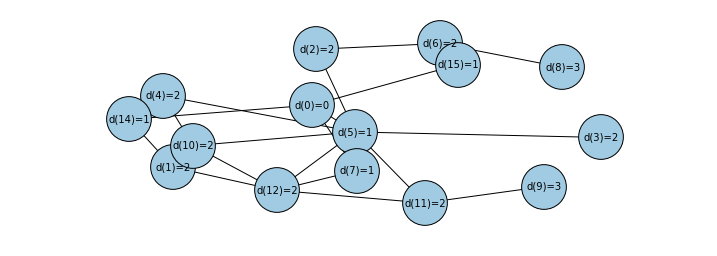

In [ ]:
def enumerate_arcs(G):
    for i,j in G.edges():
        yield i,j
        yield j,i
d = { 0:0 }
maj = 1
while maj > 0:
    maj = 0
    for i,j in enumerate_arcs(G):
        if i in d:
            x = d[i] + 1
            if j in d: 
                if d[j] > x :
                    d[j] = x
                    maj += 1
            else:
                d[j] = x
                maj += 1
labels={ g:"d({0})={1}".format(g,d[g]) for g in G.nodes() if g in d }
plt.figure(figsize=(12,4))
nx.draw_networkx_labels(G,pos,labels,font_size=10)
nx.draw(G,pos,node_color='#A0CBE2',node_size=2000)

Chaque valeur indique la distance d'un noeud au noeud 0. Dans ce graphe, il faut passer par trois arcs au maximum pour aller du noeud 0 à n'importe quel autre noeud.

<b>Map Reduce</b>

L'algorithme précédent a un coût proportionnel au nombre d'itérations multiplié par le nombre d'arcs et l'accès au dictionnaire `d`, soit au pire $O(|G||E|\ln_2|G|)$ où $|x|$ est le nombre d'éléments de cet ensemble. Au pire le plus grand chemin ne peut excéder le nombre de noeuds. L'autre caractéristique de cet algorithme est qu'il fait intervenir deux ensembles : les arcs `E=G.edges()` et le tableau `d`. Ce qu'il est important de retenir est que chaque itération requiert l'accès à tous les éléments du tableau `d`. Or, pour des grands graphes, `d` est trop grand pour qu'on puisse accéder à tous ses éléments à la fois. Il faut répartir `d` sur plusieurs machines.

Lorsqu'on évoque Map Reduce, une des technologies open source les plus utilisées aujourd'hui est [Hadoop](http://fr.wikipedia.org/wiki/Hadoop) et un langage associé [PIG](http://en.wikipedia.org/wiki/Pig_%28programming_tool%29). Je ne détaillerai pas le langage mais il faut retenir que sa logique est proche du [SQL](http://fr.wikipedia.org/wiki/Structured_Query_Language) et qu'on ne peut pas utiliser d'[index](http://fr.wikipedia.org/wiki/Index_(base_de_donn%C3%A9es)). Comment implémenter l'algorithme précédent en SQL en partant du principe que l'ensemble des arcs $E$ et du tableau $d$ sont des tables, qu'on peut les parcourir mais qu'on ne peut plus accéder à un élément en particulier ?

Commençons par importer les arcs du graphe dans une base SQL.

In [ ]:
import pandas
df = pandas.DataFrame( [ _ for _ in enumerate_arcs(G) ], columns=["v1","v2"])
df.head(n=3)

,v1,v2
0,0,4
1,4,0
2,0,5


In [ ]:
from pyensae.sql import Database
import os
dbfile = "graph_arcs.db3"
if os.path.exists(dbfile):
    os.remove(dbfile) # on supprime la précédente base
db = Database.fill_sql_table(df, dbfile, "arc")
db.close()

Sous Windows, vous pouvez visualiser la base de données avec le programme [SQLiteSpy](http://www.yunqa.de/delphi/doku.php/products/sqlitespy/index). Il ne reste plus qu'à écrire l'algorithme en SQL en s'inspirant de celui déjà écrit en Python. L'instruction `for` est remplacée par une instruction `SELECT`, l'instruction `if j in d:` le sera par une instruction `INNER JOIN`. Par exemple, la requête suivante retourne les colonnes `v1,v2,v3`. $v1 \longrightarrow v3$ sont des paires pour lesquelles $d(v1,v3) \leq 2$.

In [ ]:
def nolog (*l,**p):pass
db = Database(dbfile, LOG = nolog)
db.connect()
sql = """
        SELECT A.v1,A.v2,B.v2 AS v3 
        FROM arc AS A INNER JOIN arc AS B
        ON A.v2 == B.v1
        """
db.execute_view(sql)[:5]

[(0, 4, 0), (0, 4, 5), (0, 4, 7), (0, 4, 12), (4, 0, 4)]

Et la requête suivante contient toutes les paires de noeuds $v1,v2$ tels que $d(v1,v2) \leq 2$.

In [ ]:
sql = """
        SELECT A.v1,B.v2 AS v2 FROM arc AS A INNER JOIN arc AS B ON A.v2 == B.v1
        UNION ALL 
        SELECT v1,v2 FROM arc
        UNION ALL
        SELECT v1,v1 FROM arc
        """
db.execute_view(sql)[:5]

[(0, 0), (0, 6), (0, 9), (0, 10), (8, 5)]

Et maintenant on ajoute la distance puis on récupère la distance minimale pour chaque paire de noeuds :

In [ ]:
sql = """
        SELECT v1,v2,MIN(d) AS d FROM (
            SELECT A.v1,B.v2 AS v2, 2 AS d FROM arc AS A INNER JOIN arc AS B ON A.v2 == B.v1
            UNION ALL 
            SELECT v1,v2, 1 AS d FROM arc
            UNION ALL
            SELECT v1,v1, 0 AS d FROM arc
        )
        GROUP BY v1,v2
        """
db.execute_view(sql)[:5]

[(0, 0, 0), (0, 4, 1), (0, 5, 1), (0, 7, 1), (0, 8, 2)]

La distance maximale trouvée avec le premier algorithme est supérieure à 3, il faut donc ajouter une itération. Avant, on crée une *VIEW* pour éviter de recopier trop de code SQL :

In [ ]:
db.execute ("""
        CREATE VIEW iter1 AS 
            SELECT v1,v2,MIN(d) AS d FROM (
                SELECT A.v1,B.v2 AS v2, 2 AS d FROM arc AS A INNER JOIN arc AS B ON A.v2 == B.v1
                UNION ALL 
                SELECT v1,v2, 1 AS d FROM arc
                UNION ALL
                SELECT v1,v1, 0 AS d FROM arc
            )
            GROUP BY v1,v2
        """)

L'itération suivante est presque identique à la précédente. On remplace une des tables `arc` par `iter1` puis on ne garde que les distances relatives au noeud 0 :

In [ ]:
sql = """
            SELECT v1,v2,MIN(d) AS d FROM (
                SELECT A.v1,B.v2 AS v2, 2 AS d FROM iter1 AS A INNER JOIN arc AS B ON A.v2 == B.v1
                UNION ALL 
                SELECT v1,v2, d FROM iter1
            )
            GROUP BY v1,v2 
            HAVING v1 == 0
        """
db.execute_view(sql)

[(0, 0, 0),
 (0, 2, 2),
 (0, 4, 1),
 (0, 5, 1),
 (0, 6, 2),
 (0, 7, 1),
 (0, 8, 2),
 (0, 10, 2),
 (0, 11, 2),
 (0, 12, 2),
 (0, 13, 2),
 (0, 14, 2),
 (0, 15, 2)]

On ajoute des itérations :

In [ ]:
db.execute ("""CREATE VIEW iter2 AS 
            SELECT v1,v2,MIN(d) AS d FROM (
                SELECT A.v1,B.v2 AS v2, A.d+1 AS d FROM iter1 AS A INNER JOIN arc AS B ON A.v2 == B.v1
                UNION ALL 
                SELECT v1,v2, d FROM iter1
            )
            GROUP BY v1,v2 ;""")
db.execute ("""CREATE VIEW iter3 AS 
            SELECT v1,v2,MIN(d) AS d FROM (
                SELECT A.v1,B.v2 AS v2, A.d+1 AS d FROM iter2 AS A INNER JOIN arc AS B ON A.v2 == B.v1
                UNION ALL 
                SELECT v1,v2, d FROM iter2
            )
            GROUP BY v1,v2 ;""")
db.execute ("""CREATE VIEW iter4 AS 
            SELECT v1,v2,MIN(d) AS d FROM (
                SELECT A.v1,B.v2 AS v2, A.d+1 AS d FROM iter3 AS A INNER JOIN arc AS B ON A.v2 == B.v1
                UNION ALL 
                SELECT v1,v2, d FROM iter3
            )
            GROUP BY v1,v2 ;""")

sql = """
            SELECT v1,v2,MIN(d) AS d FROM (
                SELECT A.v1,B.v2 AS v2, A.d+1 AS d FROM iter4 AS A INNER JOIN arc AS B ON A.v2 == B.v1
                UNION ALL 
                SELECT v1,v2, d FROM iter4
            )
            GROUP BY v1,v2 
            HAVING v1 == 0
        """
db.execute_view(sql)

[(0, 0, 0),
 (0, 1, 5),
 (0, 2, 3),
 (0, 3, 4),
 (0, 4, 1),
 (0, 5, 1),
 (0, 6, 3),
 (0, 7, 1),
 (0, 8, 2),
 (0, 9, 6),
 (0, 10, 2),
 (0, 11, 3),
 (0, 12, 2),
 (0, 13, 2),
 (0, 14, 3),
 (0, 15, 2)]

Il suffit de créer autant de VIEW que d'itérations. Mais ce mécanisme apparaît moins souple que la version implémentée en langage Python. La première difficulté est le nombre d'itérations qui n'est pas connu à l'avance. Avec le langage SQL, ce nombre d'itérations ne peut pas dépendre des données. Il en est de même avec un langage Map Reduce.

En revanche, il est plus facile de paralléliser la version SQL sur plusieurs machines car une requête SQL s'y prête bien. Les problèmes de parallélisation surviennent généralement si le graphe est très connecté : l'instruction `INNER JOIN` a un coût inférieur à $O(|E||G|^2)$. Cette valeur est supérieure au coût de l'algorithme codé en Python car il est réalisé sans index. Moins il y a d'arcs, plus c'est rapide. 

Cependant, dans les faits, on remarque qu'il suffit qu'un petit nombre de noeuds soient connectés à beaucoup d'autres pour que des problèmes de parallélisation surviennent. En règle générale, chaque machine reçoit toutes les données qui partagent la même clé utilisée dans l'instruction `INNER JOIN`. Si la quantité de données associée à une clé est très grande, il est possible que la machine traitant les données de cette clé termine son exécution bien plus tard que toutes les autres. 

C'est dans ce cas qu'il faut parfois user d'imagination.